In [ ]:
from prepare_language_folder import prepare_language_folder
from preprocessing.data_collection.multipleye_data_collection import MultipleyeDataCollection
from pathlib import Path

In [2]:
data_collection_name = 'MultiplEYE_SQ_CH_Zurich_1_2025'

If necessary, prepare the data folder by unzipping the downloaded files. Works only for MultiplEYE and MeRID data collections so far. Also, there might be some manual steps necessary.

In [ ]:
prepare_language_folder(data_collection_name)

In [4]:
this_repo = Path().resolve()
data_folder_path = this_repo / "data" / data_collection_name

## Converting EDF to ASCII and Performing Data Collection for Multipleye

In [ ]:
multipleye_sq = MultipleyeDataCollection.create_from_data_folder(data_folder_path)

In [ ]:
sessions = [s for s in multipleye_sq]
sessions[0]

## Creating Gaze Frame from ASCII File

In [7]:
from pymovements.gaze.io import from_asc

raw_file = sessions[0]['asc_path']

gaze = from_asc(
    file=raw_file,
    events=True
)

# Set screen parameters for degrees of visual angle conversion
# a must-have in order to convert pixels to degrees of visual angle
gaze.experiment.screen.distance_cm = 60 
gaze.experiment.screen.height_cm = 28
gaze.experiment.screen.width_cm = 37

## Saving Gaze

In [8]:
# Save data from the Gaze object in the provided directory.

#     Depending on parameters it may save three files:
#     * preprocessed gaze in samples (samples)
#     * calculated gaze events (events)
#     * metadatata experiment in YAML file (experiment).

#     Verbosity level (0: no print output, 1: show progress bar, 2: print saved filepaths)

#     Data will be saved as feather or csv files.
#     there is no built-in pickle save function in pymovements

# more human-readable csv format
gaze.save(Path(raw_file).parent, save_events=True,
    save_samples=True, save_experiment=True, extension='csv', verbose=1)

time,pupil,pixel
i64,f64,list[f64]
2626911,996.0,"[50.7, 122.8]"
2626912,996.0,"[50.4, 124.0]"
2626913,998.0,"[50.8, 123.3]"
2626914,995.0,"[51.8, 123.0]"
2626915,995.0,"[51.6, 123.1]"
…,…,…
10558292,879.0,"[278.5, 885.7]"
10558293,880.0,"[278.7, 886.1]"
10558294,874.0,"[277.6, 885.6]"


## Calculating Fixations

### Compute gaze positions

In [9]:
# Compute gaze positions in degrees of visual angle from pixel position coordinates.
# This method requires a properly initialized Gaze.experiment attribute.
# After success, Gaze.samples is extended by the resulting dva position columns.

gaze.pix2deg()

### Compute gaze velocity

There are several available methods for computing velocity from the positional coordinates.

| Method               | Description                                                                                                                                                  |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **`preceding`**      | Computes velocity as the difference between the current and preceding sample.        | 
| **`neighbors`**      | Uses the difference between the subsequent and preceding samples, centered on the current sample.              |
| **`fivepoint`**      | Computes velocity from the mean of the two preceding and two following samples, divided by six.                    |
| **`savitzky_golay`** | Applies a Savitzky–Golay filter to fit a local polynomial of fixed degree over a sliding window. |
| **`smooth`**         | Alias of `fivepoint` for backward compatibility.                                                                                                             |


Compute gaze velocity from dva position coordinates. This requires a properly initialized Gaze.experiment attribute.
After success, Gaze.samples is extended by the resulting velocity columns.
For more information: https://github.com/pymovements/pymovements/blob/67b7d8b1a22a88fd77fde370b57d0920a7ee8dc8/src/pymovements/gaze/transforms.py#L489

In [10]:
gaze.pos2vel('smooth')

In [11]:
gaze

time,pupil,pixel,position,velocity
i64,f64,list[f64],list[f64],list[f64]
2626911,996.0,"[50.7, 122.8]","[-15.865846, -9.976727]","[null, null]"
2626912,996.0,"[50.4, 124.0]","[-15.873338, -9.945663]","[null, null]"
2626913,998.0,"[50.8, 123.3]","[-15.863349, -9.963784]","[9.574565, -3.020216]"
2626914,995.0,"[51.8, 123.0]","[-15.838371, -9.97155]","[4.57903, 0.431618]"
2626915,995.0,"[51.6, 123.1]","[-15.843367, -9.968961]","[-12.486222, 10.786545]"
…,…,…,…,…
10558292,879.0,"[278.5, 885.7]","[-10.031679, 10.170738]","[-6.543484, -14.647334]"
10558293,880.0,"[278.7, 886.1]","[-10.026444, 10.181079]","[-4.36183, -12.924581]"
10558294,874.0,"[277.6, 885.6]","[-10.055232, 10.168153]","[5.235921, 4.738033]"


### Compute New Fixations

We can detect fixations by applying a specific event detection method

#### Threshold Identification (I-VT or IVT) algorithm.
The IVT algorithm separates fixation and saccade points based on their point-to-point velocities. It classifies each point as a fixation if the velocity is below the given velocity threshold. Consecutive fixation points are merged into one fixation. 20 degrees/sec is often set as a default threshold. 
You can find more information about the algorithm in the documentation:
https://pymovements.readthedocs.io/en/stable/reference/api/pymovements.events.detection.ivt.html

#### Dispersion-Threshold Identification (I-DT or IDT) algorithm

The algorithm identifies fixations by grouping consecutive points within a maximum separation (dispersion) threshold and a minimum duration threshold. The algorithm uses a moving window to check the dispersion of the points in the window. If the dispersion is below the threshold, the window represents a fixation, and the window is expanded until the dispersion is above threshold.
Read more about our implementation of the algorithm here: 
https://pymovements.readthedocs.io/en/stable/reference/api/pymovements.events.detection.idt.html 

In [12]:
# # We test maximum velocity thresholds of 10, 20, 30, 40 degrees/s.
# # The default value is 20 degrees/s.
# for th in [10, 20, 30]:
#     # eye parameter options: 'auto', 'left', 'right' or 'None'
#     # Default 'auto' deduces from the available columns in the order: 'right', 'left', 'eye'
#     # If clear=True, event DataFrame will be overwritten with new DataFrame
#     # instead of being merged into the existing one.
#     gaze.detect(method="ivt", velocity_threshold=th, eye='auto', clear=False)
#     print(th, gaze.events.frame["name"].unique())

In [13]:
gaze.detect(method="ivt", velocity_threshold=20, eye='auto', clear=False, name="fixation.ivt")
# You can now see the detected fixations in the gaze.events DataFrame under the name "fixation.ivt"
gaze

time,pupil,pixel,position,velocity
i64,f64,list[f64],list[f64],list[f64]
2626911,996.0,"[50.7, 122.8]","[-15.865846, -9.976727]","[null, null]"
2626912,996.0,"[50.4, 124.0]","[-15.873338, -9.945663]","[null, null]"
2626913,998.0,"[50.8, 123.3]","[-15.863349, -9.963784]","[9.574565, -3.020216]"
2626914,995.0,"[51.8, 123.0]","[-15.838371, -9.97155]","[4.57903, 0.431618]"
2626915,995.0,"[51.6, 123.1]","[-15.843367, -9.968961]","[-12.486222, 10.786545]"
…,…,…,…,…
10558292,879.0,"[278.5, 885.7]","[-10.031679, 10.170738]","[-6.543484, -14.647334]"
10558293,880.0,"[278.7, 886.1]","[-10.026444, 10.181079]","[-4.36183, -12.924581]"
10558294,874.0,"[277.6, 885.6]","[-10.055232, 10.168153]","[5.235921, 4.738033]"


## Calculating Saccades

Saccades are rapid eye movements that shift the point of fixation from one location to another. We detect saccades (or micro-saccades) from velocity gaze sequence. The `microsaccades` algorithm has a noise-adaptive velocity threshold parameter, which can be set explicitly.

The minimum saccade duration is specified in the units used in ``timesteps``. If ``timesteps`` is None, then ``minimum_duration`` is specified in numbers of samples. Default: 6

In [14]:
import polars as pl

In [15]:
# gaze.detect('microsaccades', minimum_duration=12)

# gaze.events.frame.filter(pl.col("name") == "saccades").head()

# You can experiment with different minimum durations for saccade detection
# for md in [0.1, 5, 10, 12, 20, 100]:
#     gaze.detect("microsaccades", minimum_duration=md)

#     print(md, gaze.events.frame.filter(pl.col("name") == "saccade").height)

In [16]:
gaze.detect('microsaccades', minimum_duration=12)
gaze

time,pupil,pixel,position,velocity
i64,f64,list[f64],list[f64],list[f64]
2626911,996.0,"[50.7, 122.8]","[-15.865846, -9.976727]","[null, null]"
2626912,996.0,"[50.4, 124.0]","[-15.873338, -9.945663]","[null, null]"
2626913,998.0,"[50.8, 123.3]","[-15.863349, -9.963784]","[9.574565, -3.020216]"
2626914,995.0,"[51.8, 123.0]","[-15.838371, -9.97155]","[4.57903, 0.431618]"
2626915,995.0,"[51.6, 123.1]","[-15.843367, -9.968961]","[-12.486222, 10.786545]"
…,…,…,…,…
10558292,879.0,"[278.5, 885.7]","[-10.031679, 10.170738]","[-6.543484, -14.647334]"
10558293,880.0,"[278.7, 886.1]","[-10.026444, 10.181079]","[-4.36183, -12.924581]"
10558294,874.0,"[277.6, 885.6]","[-10.055232, 10.168153]","[5.235921, 4.738033]"


### Areas Of Interest

### Loading AOI File into DataFrame

In [17]:
from pymovements.stimulus.text import from_file

In [18]:
aoi_chars_files_folder = "data/MultiplEYE_SQ_CH_Zurich_1_2025/eye-tracking-sessions/data_piloting_stimuli_MultiplEYE_SQ_CH_Zurich_1_2025participant_id_1_to_5/aoi_stimuli_sq_ch_1/"

# concatenate all available AOI character files into one DataFrame
# To make your combined AOI dataset match the temporal order of the gaze data, 
# you must concatenate AOIs in the same sequence as the participant saw them.

# option without questions
# aoi_chars_file = "concatenated_aoi_no_questions.csv"

# option with questions
aoi_chars_file = "concatenated_aoi_all.csv"

stimulus = from_file(
    aoi_path=aoi_chars_file,
    aoi_column="char",
    start_x_column="top_left_x",
    start_y_column="top_left_y",
    width_column="width",
    height_column="height",
    page_column="page",
)

stimulus.aois.head(10)

char_idx,char,top_left_x,top_left_y,width,height,char_idx_in_line,line_idx,page,word_idx,word_idx_in_line,word
i64,str,f64,f64,i64,i64,i64,i64,str,i64,i64,str
0,"""H""",81.0,89.0,14,33,0,0,"""page_1""",0,0,"""Hëna"""
1,"""ë""",95.0,89.0,14,33,1,0,"""page_1""",0,0,"""Hëna"""
2,"""n""",109.0,89.0,14,33,2,0,"""page_1""",0,0,"""Hëna"""
3,"""a""",123.0,89.0,14,33,3,0,"""page_1""",0,0,"""Hëna"""
4,"""h""",81.0,184.7,14,33,0,1,"""page_1""",1,0,"""https://sq.wikipedia.org/wiki/…"
5,"""t""",95.0,184.7,14,33,1,1,"""page_1""",1,0,"""https://sq.wikipedia.org/wiki/…"
6,"""t""",109.0,184.7,14,33,2,1,"""page_1""",1,0,"""https://sq.wikipedia.org/wiki/…"
7,"""p""",123.0,184.7,14,33,3,1,"""page_1""",1,0,"""https://sq.wikipedia.org/wiki/…"
8,"""s""",137.0,184.7,14,33,4,1,"""page_1""",1,0,"""https://sq.wikipedia.org/wiki/…"


### Mapping Fixations to AOI 

In [19]:
print(gaze.samples.columns)

['time', 'pupil', 'pixel', 'position', 'velocity']


In [20]:
#  We map each gaze point to an aoi, considering the boundary still part of the area of interest.

# explode the list column "pixel" into two numeric columns
# drop rows with null values in either pixel_xr or pixel_yr

gaze.samples = gaze.samples.with_columns([
    pl.col("pixel").list.get(0).alias("pixel_xr"),
    pl.col("pixel").list.get(1).alias("pixel_yr"),
]).drop_nulls(subset=["pixel_xr", "pixel_yr"])

In [21]:
# How many samples?
print(len(gaze.samples))

# How many AOIs?
print(stimulus.aois.height)


3474402
39924


In [22]:
subset = gaze.samples.head(40000)
gaze_small = gaze.clone()
gaze_small.samples = subset
gaze_small.map_to_aois(aoi_dataframe=stimulus, eye="auto", gaze_type="pixel")

40000it [00:19, 2087.22it/s]


In [23]:
gaze_small.samples.columns

['time',
 'pupil',
 'pixel_xr',
 'pixel_yr',
 'pixel_x',
 'pixel_y',
 'position_x',
 'position_y',
 'velocity_x',
 'velocity_y',
 'char_idx',
 'char',
 'top_left_x',
 'top_left_y',
 'width',
 'height',
 'char_idx_in_line',
 'line_idx',
 'page',
 'word_idx',
 'word_idx_in_line',
 'word']

In [24]:
gaze_small.samples.head(10)


time,pupil,pixel_xr,pixel_yr,pixel_x,pixel_y,position_x,position_y,velocity_x,velocity_y,char_idx,char,top_left_x,top_left_y,width,height,char_idx_in_line,line_idx,page,word_idx,word_idx_in_line,word
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,f64,f64,i64,i64,i64,i64,str,i64,i64,str
2626911,996.0,50.7,122.8,50.7,122.8,-15.865846,-9.976727,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2626912,996.0,50.4,124.0,50.4,124.0,-15.873338,-9.945663,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2626913,998.0,50.8,123.3,50.8,123.3,-15.863349,-9.963784,9.574565,-3.020216,null,null,null,null,null,null,null,null,null,null,null,null
2626914,995.0,51.8,123.0,51.8,123.0,-15.838371,-9.97155,4.57903,0.431618,null,null,null,null,null,null,null,null,null,null,null,null
2626915,995.0,51.6,123.1,51.6,123.1,-15.843367,-9.968961,-12.486222,10.786545,null,null,null,null,null,null,null,null,null,null,null,null
2626916,992.0,50.7,124.3,50.7,124.3,-15.865846,-9.937896,-18.313839,8.629072,null,null,null,null,null,null,null,null,null,null,null,null
2626917,995.0,48.9,124.5,48.9,124.5,-15.91079,-9.932718,-10.40577,8.198807,null,null,null,null,null,null,null,null,null,null,null,null
2626918,995.0,50.1,123.6,50.1,123.6,-15.88083,-9.956018,2.496318,6.473157,null,null,null,null,null,null,null,null,null,null,null,null
2626919,993.0,49.7,125.7,49.7,125.7,-15.890818,-9.901647,5.825883,6.904037,null,null,null,null,null,null,null,null,null,null,null,null


/Users/anastassiashaitarova/miniforge3/envs/pymovements_user/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


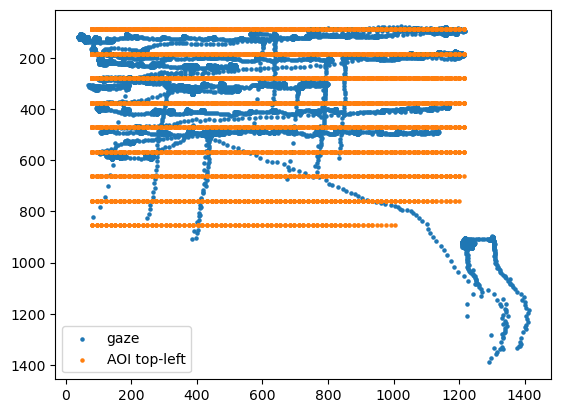

In [25]:
import matplotlib.pyplot as plt

plt.scatter(gaze_small.samples["pixel_xr"], gaze_small.samples["pixel_yr"],
            s=5, label="gaze")
plt.scatter(stimulus.aois["top_left_x"], stimulus.aois["top_left_y"],
            s=5, label="AOI top-left")
plt.legend(); plt.gca().invert_yaxis()
plt.show()


In [27]:
# gaze.map_to_aois(
#     aoi_dataframe=stimulus,
#     eye="auto",
#     gaze_type="pixel"
# )

Step 1 pf peyepline: create the gaze frame.

	-- data collection folder
	---- ...
	---- fixations
	---- saccades(?)
	---- reading_measures
	---- raw_data (i.e. gaze sample csv)